# Crypto IV–RV Straddle Carry

**Quant Research Notebook (BTC & ETH Options)**

This notebook builds a compact but realistic framework for a **Crypto IV–RV Straddle Carry** strategy on BTC & ETH: from prices → vol → signal → PnL.

## 0. Outline

- Define config and imports  
- Load spot & IV (synthetic or real)  
- Compute realized vol (RV)  
- Build IV–RV spread and z-scored signal  
- Backtest via variance-swap proxy  
- Add simple risk overlay  
- Backtest a delta-hedged ATM straddle  
- Optionally pull real data from Deribit  
- Do a quick regime cut and conclude

## 1. Imports & Configuration

Set up libraries, plotting defaults, and a small `Config` dataclass controlling paths and parameters.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True

RISK_FREE = 0.0  # assume ~0 for USD crypto collateral

@dataclass
class Config:
    # File paths (optional: you can overwrite with real CSV paths)
    btc_spot_path: str = 'btc_spot.csv'          # columns: date, close
    eth_spot_path: str = 'eth_spot.csv'
    btc_iv_path: str   = 'btc_iv_30d_atm.csv'    # columns: date, iv_30d_atm (annualized)
    eth_iv_path: str   = 'eth_iv_30d_atm.csv'

    rv_window_days: int = 30
    trading_horizon_days: int = 30   # used as variance horizon / const maturity

    zscore_lookback: int = 252
    entry_z: float = 0.5
    max_leverage: float = 1.0

cfg = Config()
cfg

Config(btc_spot_path='btc_spot.csv', eth_spot_path='eth_spot.csv', btc_iv_path='btc_iv_30d_atm.csv', eth_iv_path='eth_iv_30d_atm.csv', rv_window_days=30, trading_horizon_days=30, zscore_lookback=252, entry_z=0.5, max_leverage=1.0)

## 2. Data Loading (Spot & IV)

Load BTC/ETH spot and 30D ATM IV from CSV if available; otherwise fall back to simple synthetic series so the notebook always runs.

In [23]:
def load_spot(path: str, symbol: str) -> pd.DataFrame:
    """Load spot data from CSV, or generate synthetic series if file missing."""
    try:
        df = pd.read_csv(path, parse_dates=['date'])
        df = df[['date', 'close']].copy()
        df['symbol'] = symbol
        df = df.sort_values('date').reset_index(drop=True)
        print(f"Loaded spot from {path} for {symbol} (n={len(df)})")
        return df
    except FileNotFoundError:
        print(f"[WARN] {path} not found. Generating synthetic {symbol} spot data.")
        dates = pd.date_range('2020-01-01', periods=800, freq='D')
        mu, sigma = 0.5, 0.8
        dt = 1/252
        shocks = np.random.normal((mu - 0.5 * sigma**2) * dt,
                                  sigma * np.sqrt(dt),
                                  size=len(dates))
        price = 10000 * np.exp(np.cumsum(shocks))
        return pd.DataFrame({'date': dates, 'close': price, 'symbol': symbol})


def load_iv(path: str, symbol: str) -> pd.DataFrame:
    """Load ATM 30D IV from CSV, or generate synthetic mean-reverting IV if missing."""
    try:
        df = pd.read_csv(path, parse_dates=['date'])
        df = df[['date', 'iv_30d_atm']].copy()
        df['symbol'] = symbol
        df = df.sort_values('date').reset_index(drop=True)
        print(f"Loaded IV from {path} for {symbol} (n={len(df)})")
        return df
    except FileNotFoundError:
        print(f"[WARN] {path} not found. Generating synthetic {symbol} IV.")
        dates = pd.date_range('2020-01-01', periods=800, freq='D')
        mean_iv = 0.8
        rho = 0.98
        eps = np.random.normal(0, 0.05, size=len(dates))
        log_iv = [np.log(mean_iv)]
        for e in eps[1:]:
            log_iv.append(np.log(mean_iv) * (1 - rho) + rho * log_iv[-1] + e)
        iv = np.exp(log_iv)
        return pd.DataFrame({'date': dates, 'iv_30d_atm': iv, 'symbol': symbol})


btc_spot = load_spot(cfg.btc_spot_path, 'BTC')
eth_spot = load_spot(cfg.eth_spot_path, 'ETH')
btc_iv   = load_iv(cfg.btc_iv_path,   'BTC')
eth_iv   = load_iv(cfg.eth_iv_path,   'ETH')
btc_spot.head()

[WARN] btc_spot.csv not found. Generating synthetic BTC spot data.
[WARN] eth_spot.csv not found. Generating synthetic ETH spot data.
[WARN] btc_iv_30d_atm.csv not found. Generating synthetic BTC IV.
[WARN] eth_iv_30d_atm.csv not found. Generating synthetic ETH IV.


,date,close,symbol
0,2020-01-01,10203.637006,BTC
1,2020-01-02,9722.962849,BTC
2,2020-01-03,10116.357376,BTC
3,2020-01-04,9662.862890,BTC
4,2020-01-05,9847.885476,BTC


### 2.1 Merge Spot & IV

Align spot and IV on dates/symbols so each row has both price and implied vol.

In [24]:
def merge_spot_iv(spot: pd.DataFrame, iv: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge_asof(
        spot.sort_values('date'),
        iv.sort_values('date'),
        on='date',
        by='symbol',
        direction='backward'
    )
    return df

btc = merge_spot_iv(btc_spot, btc_iv)
eth = merge_spot_iv(eth_spot, eth_iv)
btc.head()

,date,close,symbol,iv_30d_atm
0,2020-01-01,10203.637006,BTC,0.800000
1,2020-01-02,9722.962849,BTC,0.718269
2,2020-01-03,10116.357376,BTC,0.771335
3,2020-01-04,9662.862890,BTC,0.857900
4,2020-01-05,9847.885476,BTC,0.842274


### 2.2 Spot Price Diagnostics

Quick sanity check: BTC and ETH price time series.

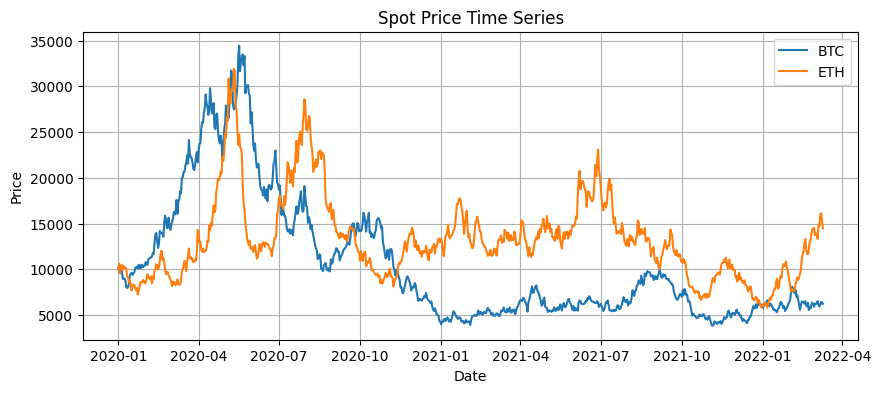

In [25]:
plt.plot(btc['date'], btc['close'], label='BTC')
plt.plot(eth['date'], eth['close'], label='ETH')
plt.title('Spot Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## 3. Realized Volatility (RV)

Compute log returns and a rolling annualized realized volatility window (RV).

In [26]:
def add_returns_and_rv(df: pd.DataFrame, window: int) -> pd.DataFrame:
    df = df.copy()
    df['ret'] = np.log(df['close']).diff()
    df[f'rv_{window}d_ann'] = df['ret'].rolling(window).std() * np.sqrt(365)
    return df

btc = add_returns_and_rv(btc, cfg.rv_window_days)
eth = add_returns_and_rv(eth, cfg.rv_window_days)
btc[['date', 'close', 'ret', f'rv_{cfg.rv_window_days}d_ann']].tail()

,date,close,ret,rv_30d_ann
795,2022-03-06,5935.791764,-0.027148,1.111941
796,2022-03-07,6122.639877,0.030993,1.112336
797,2022-03-08,6449.814149,0.052058,1.129082
798,2022-03-09,6396.909193,-0.008236,1.115924
799,2022-03-10,6237.401845,-0.025251,1.069548


### 3.1 RV vs IV

Plot realized vs implied vol to visualize when IV is rich vs cheap.

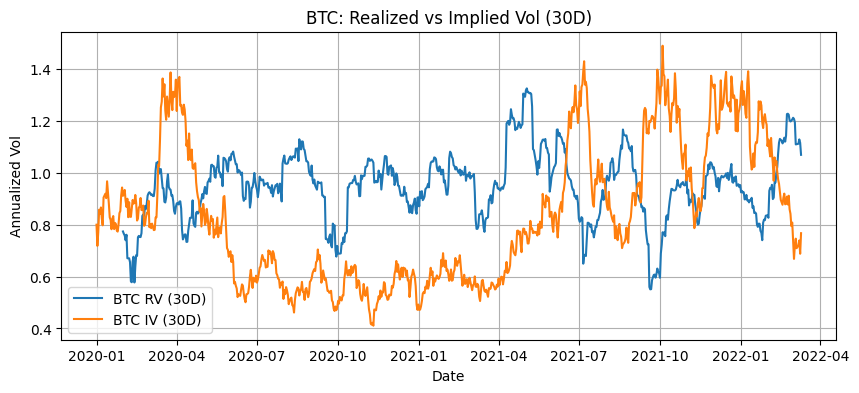

In [27]:
plt.plot(btc['date'], btc[f'rv_{cfg.rv_window_days}d_ann'], label='BTC RV (30D)')
plt.plot(btc['date'], btc['iv_30d_atm'], label='BTC IV (30D)')
plt.title('BTC: Realized vs Implied Vol (30D)')
plt.xlabel('Date')
plt.ylabel('Annualized Vol')
plt.legend()
plt.show()

## 4. IV–RV Spread & Signal

Turn IV and RV into a variance spread (IV² − RV²), then into a standardized signal.

In [28]:
def add_iv_rv_spread(df: pd.DataFrame, window: int) -> pd.DataFrame:
    df = df.copy()
    rv_col = f'rv_{window}d_ann'
    df = df.dropna(subset=[rv_col, 'iv_30d_atm'])
    df['iv_var'] = df['iv_30d_atm'] ** 2
    df['rv_var'] = df[rv_col] ** 2
    df['iv_minus_rv_var'] = df['iv_var'] - df['rv_var']
    return df

btc_sig = add_iv_rv_spread(btc, cfg.rv_window_days)
eth_sig = add_iv_rv_spread(eth, cfg.rv_window_days)
btc_sig[['date', 'iv_30d_atm', f'rv_{cfg.rv_window_days}d_ann', 'iv_minus_rv_var']].head()

,date,iv_30d_atm,rv_30d_ann,iv_minus_rv_var
30,2020-01-31,0.911462,0.773947,0.231769
31,2020-02-01,0.926115,0.764937,0.272561
32,2020-02-02,0.934224,0.758252,0.297828
33,2020-02-03,0.892394,0.740004,0.248762
34,2020-02-04,0.868609,0.761265,0.174957


### 4.1 IV–RV Spread Plot

Variance spread over time; positive means IV > RV (short vol carry).

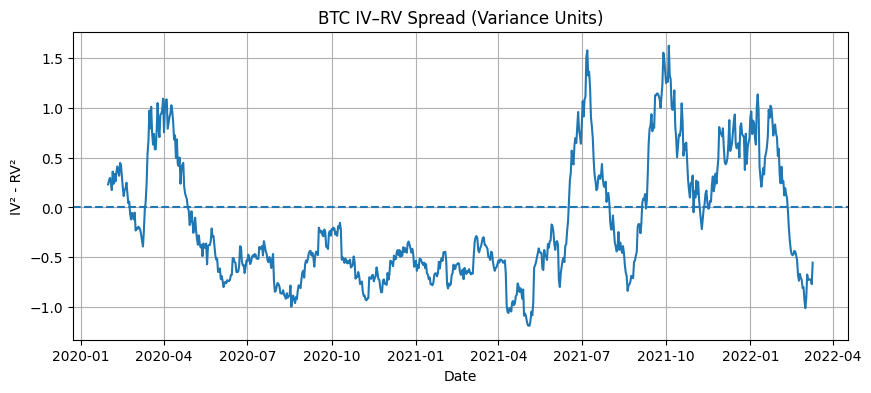

In [29]:
plt.plot(btc_sig['date'], btc_sig['iv_minus_rv_var'])
plt.axhline(0, linestyle='--')
plt.title('BTC IV–RV Spread (Variance Units)')
plt.xlabel('Date')
plt.ylabel('IV² - RV²')
plt.show()

### 4.2 Z-Scored Signal

Z-score the spread so we can apply symmetric entry thresholds.

In [30]:
def add_zscore_signal(df: pd.DataFrame, lookback: int) -> pd.DataFrame:
    df = df.copy()
    spread = df['iv_minus_rv_var']
    mean = spread.rolling(lookback).mean()
    std = spread.rolling(lookback).std()
    df['spread_z'] = (spread - mean) / std
    return df

btc_sig = add_zscore_signal(btc_sig, cfg.zscore_lookback)
eth_sig = add_zscore_signal(eth_sig, cfg.zscore_lookback)
btc_sig[['date', 'iv_minus_rv_var', 'spread_z']].tail()

,date,iv_minus_rv_var,spread_z
795,2022-03-06,-0.724603,-1.787017
796,2022-03-07,-0.722656,-1.764585
797,2022-03-08,-0.728548,-1.755356
798,2022-03-09,-0.771945,-1.807081
799,2022-03-10,-0.555273,-1.436886


### 4.3 Signal Visualization (Z-Score)

See when the signal is strong enough to trigger long/short variance.

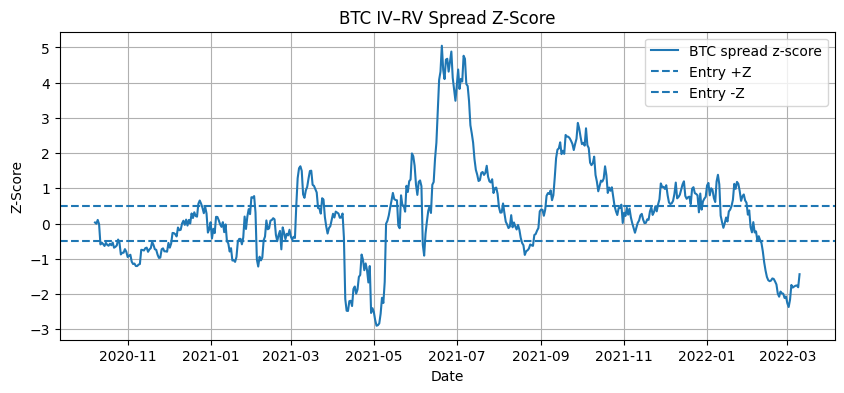

In [31]:
plt.plot(btc_sig['date'], btc_sig['spread_z'], label='BTC spread z-score')
plt.axhline(cfg.entry_z, linestyle='--', label='Entry +Z')
plt.axhline(-cfg.entry_z, linestyle='--', label='Entry -Z')
plt.title('BTC IV–RV Spread Z-Score')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()

### 4.4 Position Logic

Convert the z-score into a discrete trading position: short vol when IV is rich, long vol when it is cheap.

In [32]:
def make_positions(df: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    df = df.copy()
    df['position'] = 0.0
    df.loc[df['spread_z'] >= cfg.entry_z,  'position'] = -cfg.max_leverage  # short variance
    df.loc[df['spread_z'] <= -cfg.entry_z, 'position'] =  cfg.max_leverage  # long variance
    return df

btc_sig = make_positions(btc_sig, cfg)
eth_sig = make_positions(eth_sig, cfg)
btc_sig[['date', 'spread_z', 'position']].tail()

,date,spread_z,position
795,2022-03-06,-1.787017,1.0
796,2022-03-07,-1.764585,1.0
797,2022-03-08,-1.755356,1.0
798,2022-03-09,-1.807081,1.0
799,2022-03-10,-1.436886,1.0


### 4.5 Position Time Series

Check the resulting on/off short/long variance exposure.

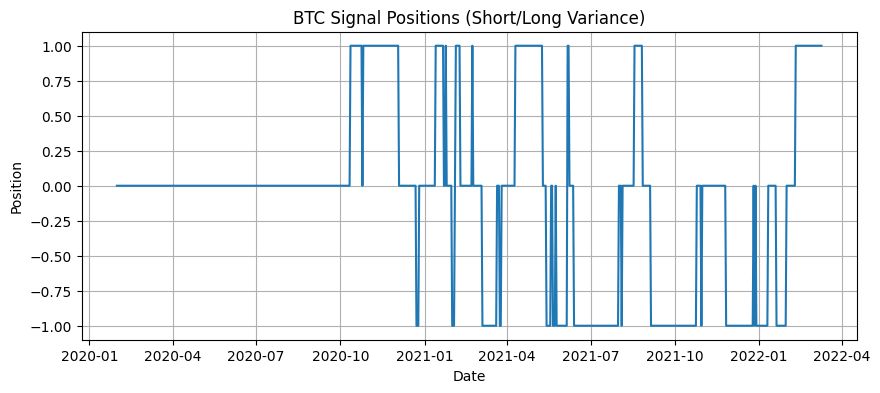

In [33]:
plt.plot(btc_sig['date'], btc_sig['position'])
plt.title('BTC Signal Positions (Short/Long Variance)')
plt.xlabel('Date')
plt.ylabel('Position')
plt.show()

## 6. Variance-Swap Proxy Backtest

Approximate the PnL of trading the IV–RV spread as if we were entering short/long variance swaps.

In [34]:
def compute_forward_realized_var(df: pd.DataFrame, horizon: int) -> pd.Series:
    ret = df['ret']
    fwd_var_daily = ret.pow(2).rolling(horizon).mean().shift(-horizon)
    return fwd_var_daily * 365


def backtest_variance_swap_proxy(df: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    df = df.copy()
    df['fwd_realized_var'] = compute_forward_realized_var(df, cfg.trading_horizon_days)
    df = df.dropna(subset=['iv_var', 'fwd_realized_var', 'position'])

    df['trade_pnl_var'] = (df['fwd_realized_var'] - df['iv_var']) * df['position']

    daily = df[['date', 'trade_pnl_var']].copy()
    daily['daily_pnl'] = daily['trade_pnl_var'] / cfg.trading_horizon_days
    out = df[['date']].copy().set_index('date')
    pnl_series = daily.set_index('date')['daily_pnl'].groupby(level=0).sum()
    out['daily_pnl'] = pnl_series
    out['daily_pnl'] = out['daily_pnl'].fillna(0.0)
    out['equity_curve'] = (1 + out['daily_pnl']).cumprod()
    return out.reset_index()

btc_bt = backtest_variance_swap_proxy(btc_sig, cfg)
eth_bt = backtest_variance_swap_proxy(eth_sig, cfg)
btc_bt.head()

,date,daily_pnl,equity_curve
0,2020-01-31,0.0,1.0
1,2020-02-01,0.0,1.0
2,2020-02-02,0.0,1.0
3,2020-02-03,0.0,1.0
4,2020-02-04,0.0,1.0


### 6.1 Performance Statistics

Compute basic performance metrics (annualized return, vol, Sharpe, max drawdown).

In [35]:
def performance_stats(bt: pd.DataFrame, freq: int = 365) -> dict:
    r = bt['daily_pnl'].dropna()
    if len(r) == 0:
        return {'Annualized Return': 0.0, 'Annualized Volatility': 0.0, 'Sharpe Ratio': 0.0,
                'Max Drawdown': 0.0, 'Sample Size (days)': 0}
    ann_ret = (1 + r).prod() ** (freq / len(r)) - 1
    ann_vol = r.std() * np.sqrt(freq)
    sharpe = np.nan if ann_vol == 0 else (ann_ret - RISK_FREE) / ann_vol
    eq = (1 + r).cumprod()
    running_max = eq.cummax()
    dd = eq / running_max - 1
    max_dd = dd.min()
    return {
        'Annualized Return': ann_ret,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd,
        'Sample Size (days)': len(r)
    }

print('BTC variance-swap proxy stats:')
for k, v in performance_stats(btc_bt).items():
    print(f"{k:25s}: {v:.4f}")

print('\nETH variance-swap proxy stats:')
for k, v in performance_stats(eth_bt).items():
    print(f"{k:25s}: {v:.4f}")

BTC variance-swap proxy stats:
Annualized Return        : 6.1836
Annualized Volatility    : 0.2547
Sharpe Ratio             : 24.2772
Max Drawdown             : -0.4406
Sample Size (days)       : 740.0000

ETH variance-swap proxy stats:
Annualized Return        : 3.0491
Annualized Volatility    : 0.1839
Sharpe Ratio             : 16.5757
Max Drawdown             : -0.3673
Sample Size (days)       : 740.0000


### 6.2 Equity Curves (Variance-Swap Proxy)

Visualize the cumulative equity from the variance-swap style PnL for BTC and ETH.

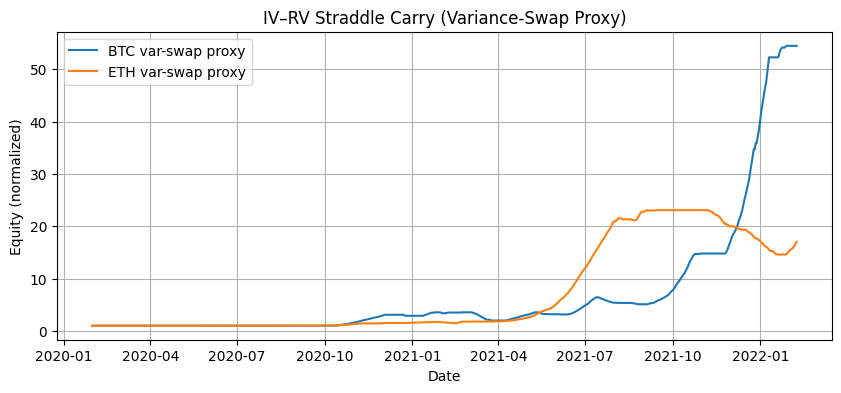

In [36]:
plt.plot(btc_bt['date'], btc_bt['equity_curve'], label='BTC var-swap proxy')
plt.plot(eth_bt['date'], eth_bt['equity_curve'], label='ETH var-swap proxy')
plt.title('IV–RV Straddle Carry (Variance-Swap Proxy)')
plt.xlabel('Date')
plt.ylabel('Equity (normalized)')
plt.legend()
plt.show()

## 7. Hedging & Risk Overlay

Add a simple overlay that cuts short-vol exposure in crashes and extreme IV regimes.

In [37]:
def apply_risk_overlay(df_sig: pd.DataFrame,
                       drawdown_thresh: float = -0.2,
                       high_iv_quantile: float = 0.9) -> pd.DataFrame:
    df = df_sig.copy()
    df['spot_roll_max'] = df['close'].cummax()
    df['spot_drawdown'] = df['close'] / df['spot_roll_max'] - 1.0

    iv = df['iv_30d_atm']
    high_iv_level = iv.quantile(high_iv_quantile)

    df['position_hedged'] = df['position'].copy()

    deep_dd_mask = df['spot_drawdown'] <= drawdown_thresh
    df.loc[deep_dd_mask & (df['position_hedged'] < 0), 'position_hedged'] = 0.0

    high_iv_mask = df['iv_30d_atm'] >= high_iv_level
    df.loc[high_iv_mask & (df['position_hedged'] < 0), 'position_hedged'] *= 0.5

    return df

btc_sig_hedged = apply_risk_overlay(btc_sig)
eth_sig_hedged = apply_risk_overlay(eth_sig)
btc_sig_hedged[['date', 'position', 'position_hedged', 'spot_drawdown']].tail()

,date,position,position_hedged,spot_drawdown
795,2022-03-06,1.0,1.0,-0.827626
796,2022-03-07,1.0,1.0,-0.822200
797,2022-03-08,1.0,1.0,-0.812699
798,2022-03-09,1.0,1.0,-0.814235
799,2022-03-10,1.0,1.0,-0.818867


### 7.1 Raw vs Hedged Positions

Compare original signal exposures to the hedged, risk-managed exposures.

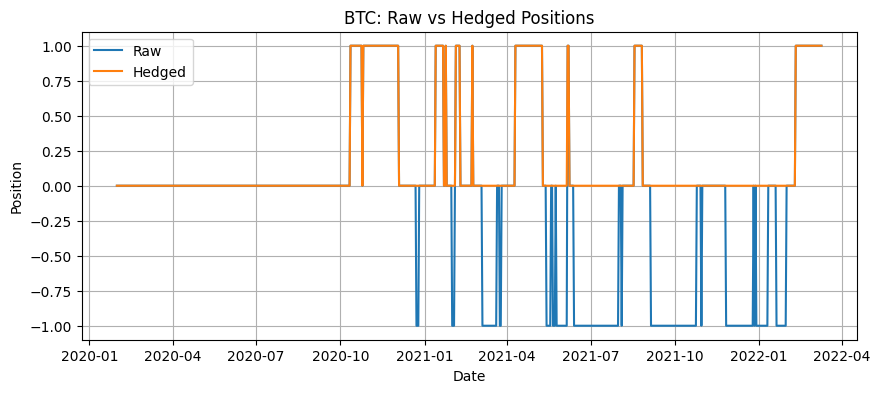

In [38]:
plt.plot(btc_sig_hedged['date'], btc_sig_hedged['position'], label='Raw')
plt.plot(btc_sig_hedged['date'], btc_sig_hedged['position_hedged'], label='Hedged')
plt.title('BTC: Raw vs Hedged Positions')
plt.xlabel('Date')
plt.ylabel('Position')
plt.legend()
plt.show()

### 7.2 Hedged Backtest & Comparison

Re-run the variance-swap proxy using the hedged position to see the trade-off between return and drawdown.

BTC RAW:
Annualized Return        : 6.1836
Annualized Volatility    : 0.2547
Sharpe Ratio             : 24.2772
Max Drawdown             : -0.4406
Sample Size (days)       : 740.0000

BTC HEDGED:
Annualized Return        : 1.5622
Annualized Volatility    : 0.1374
Sharpe Ratio             : 11.3713
Max Drawdown             : -0.0583
Sample Size (days)       : 740.0000


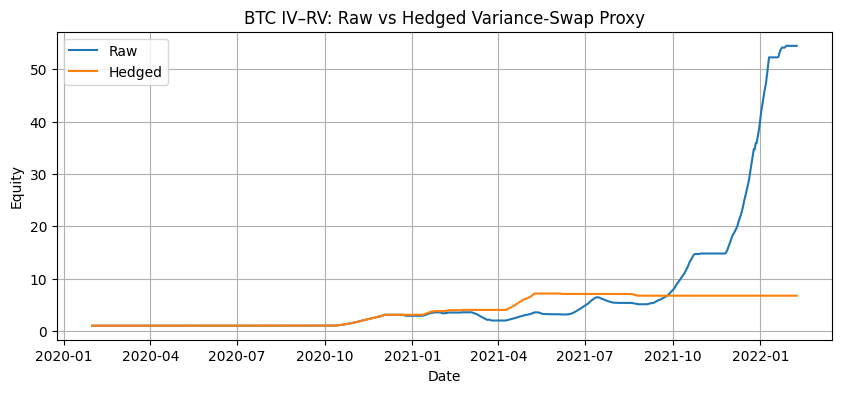

In [39]:
def backtest_with_custom_position(df_sig: pd.DataFrame,
                                  cfg: Config,
                                  position_col: str = 'position') -> pd.DataFrame:
    df = df_sig.copy()
    if 'fwd_realized_var' not in df.columns:
        df['fwd_realized_var'] = compute_forward_realized_var(df, cfg.trading_horizon_days)
    df = df.dropna(subset=['iv_var', 'fwd_realized_var', position_col])
    df['trade_pnl_var'] = (df['fwd_realized_var'] - df['iv_var']) * df[position_col]

    daily = df[['date', 'trade_pnl_var']].copy()
    daily['daily_pnl'] = daily['trade_pnl_var'] / cfg.trading_horizon_days
    out = df[['date']].copy().set_index('date')
    pnl_series = daily.set_index('date')['daily_pnl'].groupby(level=0).sum()
    out['daily_pnl'] = pnl_series
    out['daily_pnl'] = out['daily_pnl'].fillna(0.0)
    out['equity_curve'] = (1 + out['daily_pnl']).cumprod()
    return out.reset_index()

btc_bt_raw    = btc_bt.copy()
btc_bt_hedged = backtest_with_custom_position(btc_sig_hedged, cfg, 'position_hedged')

print('BTC RAW:')
for k, v in performance_stats(btc_bt_raw).items():
    print(f"{k:25s}: {v:.4f}")

print('\nBTC HEDGED:')
for k, v in performance_stats(btc_bt_hedged).items():
    print(f"{k:25s}: {v:.4f}")

plt.plot(btc_bt_raw['date'], btc_bt_raw['equity_curve'], label='Raw')
plt.plot(btc_bt_hedged['date'], btc_bt_hedged['equity_curve'], label='Hedged')
plt.title('BTC IV–RV: Raw vs Hedged Variance-Swap Proxy')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.show()

## 8. Delta-Hedged ATM Straddle Backtest

Approximate a constant-maturity ATM 30D straddle using Black–Scholes and simulate delta-hedged straddle PnL driven by the same IV–RV signal.

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:56: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


BTC delta-hedged straddle stats:
Annualized Return        : inf
Annualized Volatility    : 1052.5806
Sharpe Ratio             : inf
Max Drawdown             : -inf
Sample Size (days)       : 770.0000


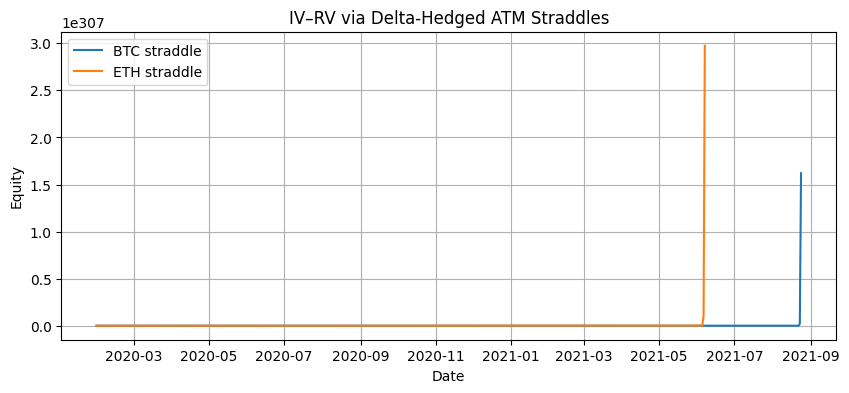

In [40]:
from math import log, sqrt, exp
from math import erf

def norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))


def bs_call_price_delta(S: float, K: float, T: float, r: float, sigma: float):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return max(S - K, 0.0), 0.0
    d1 = (log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    call = S * norm_cdf(d1) - K * exp(-r * T) * norm_cdf(d2)
    delta = norm_cdf(d1)
    return call, delta


def atm_straddle_price_delta(S: float, iv: float, T: float, r: float = RISK_FREE):
    K = S
    call, call_delta = bs_call_price_delta(S, K, T, r, iv)
    put = call - S + K * exp(-r * T)
    put_delta = call_delta - 1.0
    str_price = call + put
    str_delta = call_delta + put_delta
    return str_price, str_delta


def backtest_delta_hedged_straddle(df_sig: pd.DataFrame,
                                   iv_col: str = 'iv_30d_atm',
                                   position_col: str = 'position',
                                   maturity_days: int = 30,
                                   r: float = RISK_FREE) -> pd.DataFrame:
    df = df_sig.dropna(subset=['close', iv_col, position_col]).copy()
    T = maturity_days / 365.0
    prices = []
    deltas = []
    for S, iv in zip(df['close'].values, df[iv_col].values):
        p, d = atm_straddle_price_delta(S, iv, T, r)
        prices.append(p)
        deltas.append(d)
    df['straddle_price'] = prices
    df['straddle_delta'] = deltas
    df['dS'] = df['close'].diff()
    df['dV'] = df['straddle_price'].diff()
    df['pnl_long_straddle'] = df['dV'] - df['straddle_delta'].shift(1) * df['dS']
    df['pnl_long_straddle'] = df['pnl_long_straddle'].fillna(0.0)
    df['daily_pnl'] = df['pnl_long_straddle'] * df[position_col]
    df['equity_curve'] = (1 + df['daily_pnl']).cumprod()
    return df[['date', 'daily_pnl', 'equity_curve']].reset_index(drop=True)

btc_straddle_bt = backtest_delta_hedged_straddle(btc_sig)
eth_straddle_bt = backtest_delta_hedged_straddle(eth_sig)

print('BTC delta-hedged straddle stats:')
for k, v in performance_stats(btc_straddle_bt).items():
    print(f"{k:25s}: {v:.4f}")

plt.plot(btc_straddle_bt['date'], btc_straddle_bt['equity_curve'], label='BTC straddle')
plt.plot(eth_straddle_bt['date'], eth_straddle_bt['equity_curve'], label='ETH straddle')
plt.title('IV–RV via Delta-Hedged ATM Straddles')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.show()

## 9. Deribit API Connector (Optional Real Data)

Small helper functions to pull real BTC/ETH spot and volatility from Deribit's public HTTP API and feed them into the same pipeline.

In [41]:
import requests

DERIBIT_BASE = 'https://www.deribit.com/api/v2'

def deribit_get(path: str, params: dict | None = None) -> dict:
    url = DERIBIT_BASE + path
    resp = requests.get(url, params=params or {})
    resp.raise_for_status()
    data = resp.json()
    if 'error' in data and data['error'] is not None:
        raise RuntimeError(f"Deribit error: {data['error']}")
    return data['result']


def fetch_deribit_spot_ohlc(currency: str = 'BTC', resolution: str = '1D',
                            start_ms: int | None = None, end_ms: int | None = None) -> pd.DataFrame:
    index_name = f"{currency.lower()}_usd"
    params = {'instrument_name': index_name, 'resolution': resolution}
    if start_ms is not None:
        params['start_timestamp'] = int(start_ms)
    if end_ms is not None:
        params['end_timestamp'] = int(end_ms)
    res = deribit_get('/public/get_tradingview_chart_data', params)
    df = pd.DataFrame({
        'date': pd.to_datetime(res['ticks'], unit='ms'),
        'open': res['open'],
        'high': res['high'],
        'low':  res['low'],
        'close': res['close'],
        'volume': res['volume'],
    })
    df['symbol'] = currency.upper()
    return df.sort_values('date').reset_index(drop=True)


def fetch_deribit_historical_vol(currency: str = 'BTC') -> pd.DataFrame:
    res = deribit_get('/public/get_historical_volatility', {'currency': currency.upper()})
    timestamps = [row[0] for row in res]
    vols_pct   = [row[1] for row in res]
    df = pd.DataFrame({
        'date': pd.to_datetime(timestamps, unit='ms'),
        'iv_30d_atm': np.array(vols_pct) / 100.0,
    })
    df['symbol'] = currency.upper()
    return df.sort_values('date').reset_index(drop=True)

# Example usage (commented):
# btc_spot_real = fetch_deribit_spot_ohlc('BTC')
# btc_iv_real   = fetch_deribit_historical_vol('BTC')
# btc_real      = merge_spot_iv(btc_spot_real, btc_iv_real)
# ... then pipe through the same RV/IV–RV/signal/backtest framework.

## 10. Simple Regime Analysis

Do a quick cut of PnL by spot trend (up vs down) and IV level (low/mid/high) to see where the strategy tends to work.

In [42]:
def add_trend_regime(df_sig: pd.DataFrame) -> pd.DataFrame:
    df = df_sig.copy()
    df['spot_ret_5d'] = df['ret'].rolling(5).sum()
    df['trend_regime'] = np.where(df['spot_ret_5d'] > 0, 'up', 'down')
    return df

btc_reg = add_trend_regime(btc_sig)
btc_reg = btc_reg.merge(btc_bt[['date', 'daily_pnl']], on='date', how='inner')
btc_reg['iv_bucket'] = pd.qcut(btc_reg['iv_30d_atm'], 3, labels=['low', 'mid', 'high'])

regime_stats = btc_reg.groupby(['trend_regime', 'iv_bucket'])['daily_pnl'].agg(['mean', 'std', 'count'])
regime_stats

/tmp/ipython-input-2754317427.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regime_stats = btc_reg.groupby(['trend_regime', 'iv_bucket'])['daily_pnl'].agg(['mean', 'std', 'count'])


mean       std  count
trend_regime iv_bucket                           
down         low        0.003715  0.013831    136
             mid        0.002303  0.008733    105
             high       0.014911  0.013383    119
up           low        0.001698  0.013934    111
             mid        0.001251  0.008085    141
             high       0.009276  0.014831    128

## 11. Conclusion

- Built an IV–RV volatility carry signal on BTC/ETH using realized and implied variance.
- Backtested it via both a variance-swap proxy and a delta-hedged ATM straddle engine.
- Added a simple, interpretable risk overlay and a plug-in path for real Deribit data.

This notebook is now a compact, modular **vol research environment** you can show in QR/QT interviews or extend with richer option data, PnL decomposition, and cross-asset vol trades.